**I. Webscrapping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--------------------

In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import shutil

base_url = 'https://understat.com/league'
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

full_data = []

for league in leagues:
    for season in seasons:
        url = base_url+'/'+league+'/'+season
        res = requests.get(url)
        soup = BeautifulSoup(res.content, "lxml")

        scripts = soup.find_all('script')
        string_with_json_obj = ''
        for el in scripts:
            if 'teamsData' in el.text:
                string_with_json_obj = el.text.strip()

        ind_start = string_with_json_obj.index("('")+2
        ind_end = string_with_json_obj.index("')")
        json_data = string_with_json_obj[ind_start:ind_end]
        json_data = json_data.encode('utf8').decode('unicode_escape')
        data = json.loads(json_data)

        teams = {team_id: data[team_id]['title'] for team_id in data.keys()}

        dataframes = {}
        for team_id, team_name in teams.items():
            teams_data = [list(row.values()) for row in data[team_id]['history']]
            df = pd.DataFrame(teams_data, columns=list(data[team_id]['history'][0].keys()))
            df['club'] = team_name
            dataframes[team_name] = df
            print(f'Added data for {team_name} in {league} for {season}.')

        full_stat = pd.concat(dataframes.values())
        full_stat['league'] = league
        full_stat['season'] = season
        full_data.append(full_stat)

data = pd.concat(full_data)

column_mapping = {...} 
data = data.rename(columns=column_mapping)

data['passes_per_defensive_action'] = data['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
data['passes_per_defensive_action_offense'] = data['ppda'].apply(lambda x: x['att'])
data['passes_per_defensive_action_defense'] = data['ppda'].apply(lambda x: x['def'])
data = data.drop(['ppda', 'ppda_allowed'], axis=1)

data.to_csv('/content/understat_per_game.csv', index=False)
shutil.move('/content/understat_per_game.csv', '/content/drive/My Drive/understat_per_game.csv')

Added data for Malaga in La_liga for 2014.
Added data for Sevilla in La_liga for 2014.
Added data for Deportivo La Coruna in La_liga for 2014.
Added data for Real Sociedad in La_liga for 2014.
Added data for Espanyol in La_liga for 2014.
Added data for Getafe in La_liga for 2014.
Added data for Atletico Madrid in La_liga for 2014.
Added data for Rayo Vallecano in La_liga for 2014.
Added data for Valencia in La_liga for 2014.
Added data for Athletic Club in La_liga for 2014.
Added data for Barcelona in La_liga for 2014.
Added data for Real Madrid in La_liga for 2014.
Added data for Levante in La_liga for 2014.
Added data for Celta Vigo in La_liga for 2014.
Added data for Villarreal in La_liga for 2014.
Added data for Granada in La_liga for 2014.
Added data for Eibar in La_liga for 2014.
Added data for Cordoba in La_liga for 2014.
Added data for Elche in La_liga for 2014.
Added data for Almeria in La_liga for 2014.
Added data for Malaga in La_liga for 2015.
Added data for Sevilla in La_l

'/content/drive/My Drive/understat_per_game.csv'

In [1]:
# !pip install pyspark

-------------------

**II. Analyse exploratoire des données**

Dans cette partie, nous utilisons PySpark pour effectuer des opérations de traitement de données sur un ensemble de statistiques de football. Voici les étapes que nous suivons :

In [ ]:
# Importation de librairies
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [ ]:
spark = SparkSession.builder.appName("example").getOrCreate()

path = "/content/drive/My Drive/understat_per_game.csv"

football_stat_spark_df = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
football_stat_spark_df.printSchema()

root
 |-- h_a: string (nullable = true)
 |-- expected_goals: double (nullable = true)
 |-- expected_goals_conceded: double (nullable = true)
 |-- expected_goals_excluding_penalty: double (nullable = true)
 |-- non_penalty_expected_goals: double (nullable = true)
 |-- long_shot_outside_box: integer (nullable = true)
 |-- long_shot_outside_box_conceded: integer (nullable = true)
 |-- goals_scored: integer (nullable = true)
 |-- missed_chances: integer (nullable = true)
 |-- expected_points: double (nullable = true)
 |-- match_result: string (nullable = true)
 |-- match_date: timestamp (nullable = true)
 |-- matches_won: integer (nullable = true)
 |-- matches_drawn: integer (nullable = true)
 |-- matches_lost: integer (nullable = true)
 |-- total_points: integer (nullable = true)
 |-- non_penalty_expected_goals_difference: double (nullable = true)
 |-- club: string (nullable = true)
 |-- league: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- passes_per_defensive_acti

In [ ]:
football_stat_spark_df.show()

+---+--------------+-----------------------+--------------------------------+--------------------------+---------------------+------------------------------+------------+--------------+-------------------+------------+-------------------+-----------+-------------+------------+------------+-------------------------------------+------+-------+------+---------------------------+-----------------------------------+-----------------------------------+
|h_a|expected_goals|expected_goals_conceded|expected_goals_excluding_penalty|non_penalty_expected_goals|long_shot_outside_box|long_shot_outside_box_conceded|goals_scored|missed_chances|    expected_points|match_result|         match_date|matches_won|matches_drawn|matches_lost|total_points|non_penalty_expected_goals_difference|  club| league|season|passes_per_defensive_action|passes_per_defensive_action_offense|passes_per_defensive_action_defense|
+---+--------------+-----------------------+--------------------------------+---------------------

In [ ]:
football_stat_spark_df = football_stat_spark_df.withColumn("match_date", F.to_timestamp("match_date", "dd/MM/yyyy HH:mm"))

football_stat_spark_df = football_stat_spark_df.withColumn("match_date_only", F.date_format("match_date", "yyyy-MM-dd"))

football_stat_spark_df = football_stat_spark_df.withColumn("expected_goal_difference", football_stat_spark_df["expected_goals"] - football_stat_spark_df["expected_goals_conceded"])

football_stat_spark_df = football_stat_spark_df.withColumn('home_away', when(football_stat_spark_df['h_a'] == 'h', 'home').otherwise('away'))

football_stat_spark_df = football_stat_spark_df.drop('h_a')

indexer = StringIndexer(inputCol="home_away", outputCol="home_away_encoded")
indexed_df = indexer.fit(football_stat_spark_df).transform(football_stat_spark_df)


In [ ]:
indexed_df.show()

In [ ]:
indexed_df.describe().show()

In [ ]:
indexed_df.select("goals_scored","expected_goals", "expected_goals_conceded", "long_shot_outside_box", "long_shot_outside_box_conceded").summary("mean", "stddev", "min", "max").show()

+-------+------------------+------------------+-----------------------+---------------------+------------------------------+
|summary|      goals_scored|    expected_goals|expected_goals_conceded|long_shot_outside_box|long_shot_outside_box_conceded|
+-------+------------------+------------------+-----------------------+---------------------+------------------------------+
|   mean| 1.361049822977064|1.3451253506834642|     1.3451253506834644|    6.046000307865976|             6.046000307865976|
| stddev|1.2457480429036356|0.8591394575549244|     0.8591394575549344|    4.159981961240814|             4.159981961240798|
|    min|                 0|               0.0|                    0.0|                    0|                             0|
|    max|                10|           6.88189|                6.88189|                   42|                            42|
+-------+------------------+------------------+-----------------------+---------------------+------------------------------+


In [ ]:
date_counts = indexed_df.groupBy("match_date_only","league").count().orderBy("match_date_only")
date_counts.show()

+---------------+-------+-----+
|match_date_only| league|count|
+---------------+-------+-----+
|     2014-08-01|   RFPL|    2|
|     2014-08-02|   RFPL|    6|
|     2014-08-03|   RFPL|    6|
|     2014-08-04|   RFPL|    2|
|     2014-08-08|Ligue_1|    2|
|     2014-08-08|   RFPL|    4|
|     2014-08-09|Ligue_1|   14|
|     2014-08-09|   RFPL|    6|
|     2014-08-10|Ligue_1|    4|
|     2014-08-10|   RFPL|    6|
|     2014-08-12|   RFPL|    2|
|     2014-08-13|   RFPL|    8|
|     2014-08-14|   RFPL|    4|
|     2014-08-15|   RFPL|    2|
|     2014-08-15|Ligue_1|    2|
|     2014-08-16|Ligue_1|   12|
|     2014-08-16|    EPL|   14|
|     2014-08-16|   RFPL|    4|
|     2014-08-17|Ligue_1|    6|
|     2014-08-17|    EPL|    4|
+---------------+-------+-----+
only showing top 20 rows



In [ ]:
indexed_df.select("goals_scored").summary("mean", "stddev", "min", "max").show()

+-------+------------------+
|summary|      goals_scored|
+-------+------------------+
|   mean| 1.361049822977064|
| stddev|1.2457480429036356|
|    min|                 0|
|    max|                10|
+-------+------------------+



In [ ]:
summary_stats = (
    indexed_df
    .groupBy("league")
    .agg(
        F.mean("goals_scored").alias("mean_goals_scored"),
        F.stddev("goals_scored").alias("stddev_goals_scored"),
        F.max("goals_scored").alias("max_goals_scored")
    )
)

summary_stats.show()


+----------+------------------+-------------------+----------------+
|    league| mean_goals_scored|stddev_goals_scored|max_goals_scored|
+----------+------------------+-------------------+----------------+
|   Ligue_1|1.3212845622119815| 1.2198968691109722|               9|
|Bundesliga| 1.506558508802209| 1.3256457198668614|               8|
|       EPL|1.3797013274336283| 1.2635841966836217|               9|
|   Serie_A|1.3870833333333332|  1.217561383675209|               8|
|   La_liga| 1.313611111111111| 1.2305927021330076|              10|
|      RFPL|         1.2421875|  1.199967327353485|              10|
+----------+------------------+-------------------+----------------+



In [ ]:
indexed_df.groupBy("home_away_encoded").agg(F.mean("goals_scored").alias("mean_goals")).show()

+-----------------+------------------+
|home_away_encoded|        mean_goals|
+-----------------+------------------+
|              0.0|1.1961106265072605|
|              1.0|1.5259890194468675|
+-----------------+------------------+



In [ ]:
#goals summary

In [2]:
# ! pip install dash

-------------------------------------

Dashboard with Dash package

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

app = dash.Dash(__name__)

leagues = indexed_df.select("league").distinct().rdd.map(lambda r: r[0]).collect()
clubs = indexed_df.select("club").distinct().rdd.map(lambda r: r[0]).collect()

app.layout = html.Div([
    dcc.Dropdown(
        id='league-dropdown',
        options=[{'label': league, 'value': league} for league in leagues],
        value=leagues[0], 
        style={'width': '50%'}
    ),

    dcc.Dropdown(
        id='club-dropdown',
        style={'width': '50%'}
    ),

    dcc.Graph(id='goal-distribution'),
])



@app.callback(
    Output('club-dropdown', 'options'),
    [Input('league-dropdown', 'value')]
)
def update_club_dropdown_options(selected_league):
    filtered_clubs = indexed_df.filter(indexed_df.league == selected_league).select("club").distinct().rdd.map(lambda r: r[0]).collect()

    club_options = [{'label': club, 'value': club} for club in filtered_clubs]

    return club_options


@app.callback(
    Output('goal-distribution', 'figure'),
    [Input('league-dropdown', 'value'),
     Input('club-dropdown', 'value')]
)
def update_goal_distribution(selected_league, selected_club):
    filtered_df = indexed_df.filter((indexed_df.league == selected_league) & (indexed_df.club == selected_club))

    fig = px.histogram(filtered_df.toPandas(), x="goals_scored", nbins=20, color="season", color_discrete_sequence=px.colors.qualitative.Set3,
                       facet_col="season", facet_col_wrap=4)
    fig.update_layout(
        title='Distribution des buts marqués par saison',
        xaxis_title='Buts marqués',
        yaxis_title='Fréquence'
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


<ipython-input-18-974f3ffa1eae>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-18-974f3ffa1eae>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<IPython.core.display.Javascript object>

In [ ]:
seasons_per_club = indexed_df.groupBy("club").agg(F.countDistinct("season").alias("season_count"))


In [ ]:
max_season_count = seasons_per_club.agg(F.max("season_count")).first()[0]

clubs_present_in_all_seasons = seasons_per_club.filter(seasons_per_club["season_count"] == max_season_count).select("club")

filtered_df = indexed_df.join(clubs_present_in_all_seasons, "club", "inner")

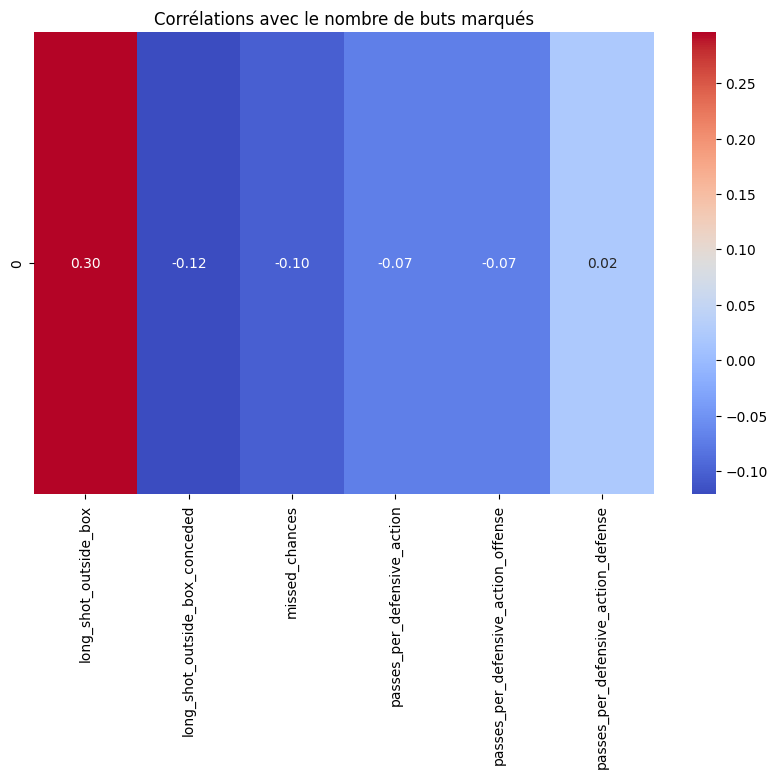

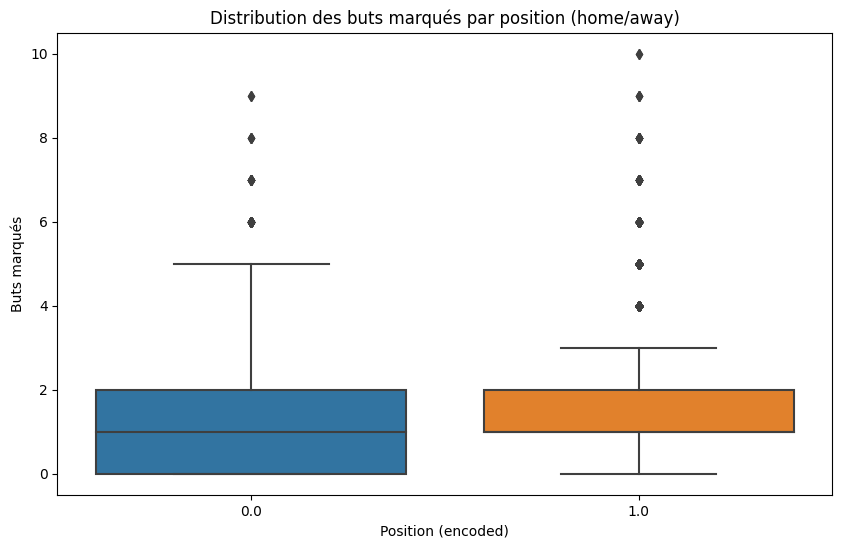

In [ ]:
correlation_matrix_goals = indexed_df.select([F.corr("goals_scored", col).alias(col) for col in indexed_df.columns if col in ["long_shot_outside_box", "long_shot_outside_box_conceded", "passes_per_defensive_action",
                    "passes_per_defensive_action_offense", "passes_per_defensive_action_defense", 'missed_chances']]).toPandas()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_goals, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Corrélations avec le nombre de buts marqués')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='home_away_encoded', y='goals_scored', data=indexed_df.toPandas())
plt.title('Distribution des buts marqués par position (home/away)')
plt.xlabel('Position (encoded)')
plt.ylabel('Buts marqués')
plt.show()

In [ ]:
top_five_leagues = ["La_liga", "EPL", "Bundesliga", "Serie_A", "Ligue_1"]
spark_df_filtered = indexed_df.filter(indexed_df["league"].isin(top_five_leagues))

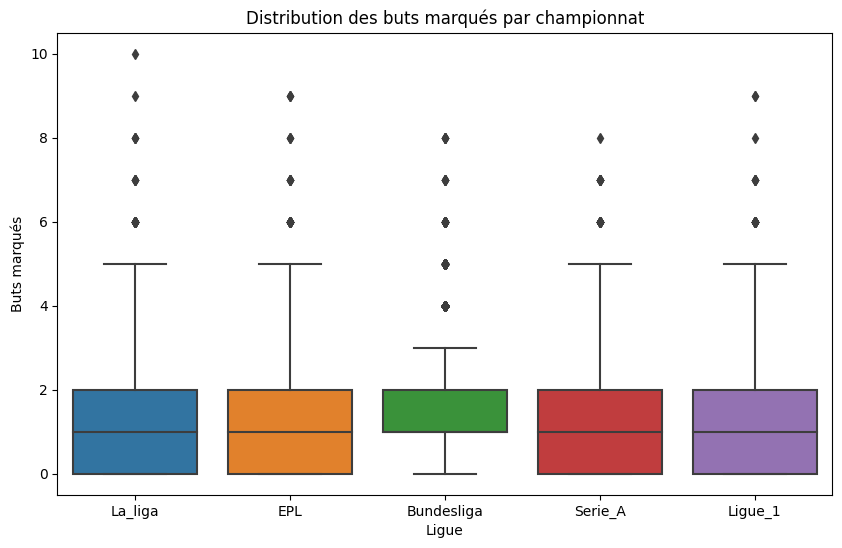

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='league', y='goals_scored', data=spark_df_filtered.toPandas())
plt.title('Distribution des buts marqués par championnat')
plt.xlabel('Ligue')
plt.ylabel('Buts marqués')
plt.show()

*Nous remarquons qu'en moyenne le nombre moyen de buts marqués par match est similaire dans les différents championnats. Cette variable ne sera donc pas utilisée dans la modélisation*


**III. Modélisation**

In [ ]:
feature_columns = ["long_shot_outside_box", "long_shot_outside_box_conceded", "passes_per_defensive_action",
                    "passes_per_defensive_action_offense", "passes_per_defensive_action_defense", 'missed_chances',
                    'home_away_encoded']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

rf = RandomForestRegressor(labelCol="goals_scored", featuresCol="features", numTrees=10)

pipeline = Pipeline(stages=[assembler, rf])

(train_data, test_data) = spark_df_filtered.randomSplit([0.7, 0.3], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

print("Pipeline Stages:")
for stage in model.stages:
    print(stage)

print("\nRandomForestRegressor Model:")
print(f"Num Trees: {model.stages[-1].getNumTrees}")

evaluator = RegressionEvaluator(labelCol="goals_scored", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)

print(f"\nMean Absolute Error (MAE): {mae}")

Pipeline Stages:
VectorAssembler_7a3d9d060671
RandomForestRegressionModel: uid=RandomForestRegressor_61b02252cc08, numTrees=100, numFeatures=7

RandomForestRegressor Model:
Num Trees: 100

Mean Absolute Error (MAE): 0.9300824749685953


In [ ]:
import pandas as pd

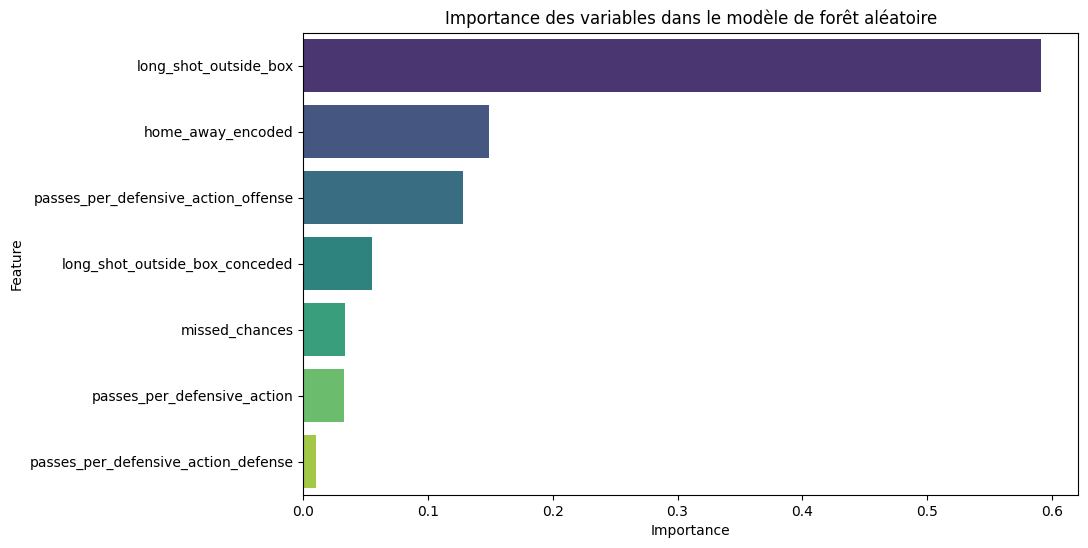

In [ ]:
importances = model.stages[-1].featureImportances.toArray()

feature_importance_df = pd.DataFrame(list(zip(feature_columns, importances)), columns=["Feature", "Importance"])

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importance des variables dans le modèle de forêt aléatoire")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
